In [1]:
from sklearn import datasets
import numpy as np
import numba
from numba import jit, njit, prange, set_num_threads
import matplotlib.pyplot as plt
import time
import seaborn as sns

### Helper Functions

In [2]:
def runtime(func, *args, **kwargs):
    """
    Returns runtime for 1 execution
    """
    start_time = time.time()
    sol = func(*args, **kwargs)
    end_time = time.time() - start_time
    return dict(func=sol,
                runtime=end_time)

def random_crop(img, crop_size=None):
    """
    Performs a random crop on an array
    """
    if crop_size is None:
        crop_size = min(img.shape[0:2])
        
    h = img.shape[0] - crop_size
    w = img.shape[1] - crop_size

    h_rnd = 0 if h == 0 else np.random.randint(0, h)   
    w_rnd = 0 if w == 0 else np.random.randint(0, w)   
    h_pos = slice(h_rnd, h_rnd + crop_size)
    w_pos = slice(w_rnd, w_rnd + crop_size)
    return img[h_pos, w_pos]

def show_convolution(f, in_img, out_img, size=10, cmap='gray'):
    """
    Displays 3 images, For the filter used, input image and output image
    """
    fig , ax = plt.subplots(1, 3, figsize=(size, size * 3))
    sns.heatmap(f, cbar=False, cmap='gray', annot=True, linewidths=1, square=True, ax=ax[0])
    ax[0].axis('off'); ax[0].set_title(f'Filter {f.shape}')
    ax[1].imshow(in_img); ax[1].axis('off'); ax[1].set_title(f'Input: {in_img.shape}')
    ax[2].imshow(out_img); ax[2].axis('off'); ax[2].set_title(f'Output: {out_img.shape}')
    plt.show()

In [3]:
sample_img = plt.imread('sample_img.jpg')
sample_img = sample_img/255

In [4]:
np.random.seed(1)
crop_sample_img = random_crop(sample_img)

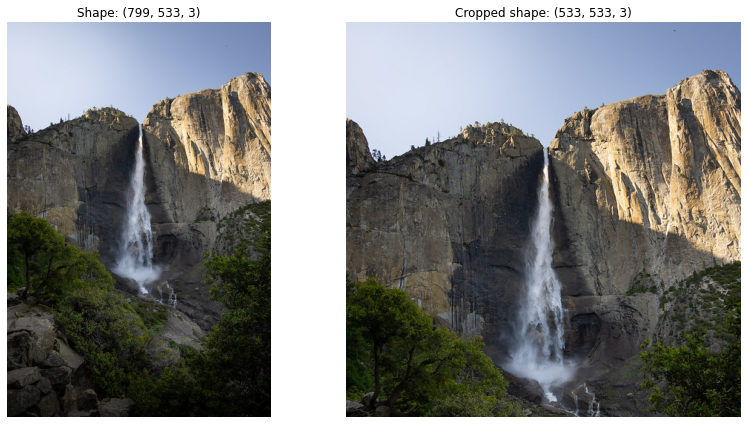

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(sample_img); plt.axis('off'); plt.title(f'Shape: {sample_img.shape}')
plt.subplot(122)
plt.imshow(crop_sample_img); plt.axis('off'); plt.title(f'Cropped shape: {crop_sample_img.shape}')
plt.tight_layout()
plt.show()

### Numpy

In [6]:
def conv_np(img, f, s=1):
    h, w, d = img.shape
    f_size = f.shape[0]
    f_sum = np.sum(f)
    
    new_size = ((h - f_size) / s) + 1
    assert s >= 1
    assert new_size % 1 == 0
    
    new_size = int(new_size)
    
    result = np.zeros((new_size, new_size, d), dtype=np.float64)
    
    for i in range(0, new_size):
        for j in range(0, new_size):
            img_seg = img[s*i:s*i+f_size, s*j:s*j+f_size, :]
            conv = np.tensordot(img_seg, f, axes=[[0, 1], [0, 1]]) / f_sum
            result[i, j, :] = conv
    return result

### Python Loops

In [7]:
def mmult_py(m1, m2):
    
    h, w = m1.shape
    result = 0
    for i in range(h):
        for j in range(w):
            result += m1[i, j] * m2[i, j]
    return result

def conv_py(img, f, s=1):
    
    h, w, d = img.shape
    f_size = f.shape[0]
    f_sum = sum(map(sum, f))
    
    new_size = ((h - f_size) / s) + 1
    assert s >= 1
    assert new_size % 1 == 0
    
    new_size = int(new_size)
    
    result = np.zeros((new_size, new_size, d), dtype=np.float64)
    
    for k in range(0, d):
        for i in range(0, new_size):
            for j in range(0, new_size):
                img_seg = img[s*i:s*i+f_size, s*j:s*j+f_size, k]
                result[i, j, k] = mmult_py(img_seg, f) / f_sum
            
    return result

### Cython

In [8]:
from conv_cy import conv_cy

### Numba

In [9]:
@njit
def mmult_nb(m1, m2):
    h, w = m1.shape
    result = 0
    for i in range(h):
        for j in range(w):
            result += m1[i, j] * m2[i, j]
    return result

@njit(parallel=True)
def conv_nb(img, f, s=1):
    
    h, w, d = img.shape
    f_size = f.shape[0]
    f_sum = f.sum()
    
    new_size = ((h - f_size) / s) + 1
    assert s >= 1
    assert new_size % 1 == 0
    
    new_size = int(new_size)
    
    result = np.zeros((new_size, new_size, d), dtype=np.float64)
    
    
    for i in prange(0, new_size):
        for k in range(0, d):
            for j in range(0, new_size):
                img_seg = img[s*i:s*i+f_size, s*j:s*j+f_size, k]
                result[i, j, k] = mmult_nb(img_seg, f) / f_sum
            
    return result

## Filters

In [10]:
emboss = np.array([[-2, -1,  0],
                   [-1,  2,  1],
                   [ 0,  1,  2]], dtype=np.float64)

sharpen = np.array([[ 0, -1,  0],
                    [-1,  5, -1],
                    [ 0, -1,  0]], dtype=np.float64)

blur = np.array([[0.625, 0.125,  0.625],
                 [0.125, 0.25,   0.125],
                 [0.625, 0.125,  0.625]], dtype=np.float64)

In [11]:
_ = conv_nb(crop_sample_img, emboss, 1)

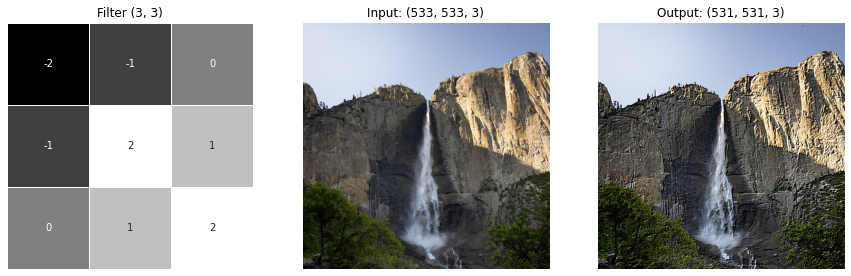

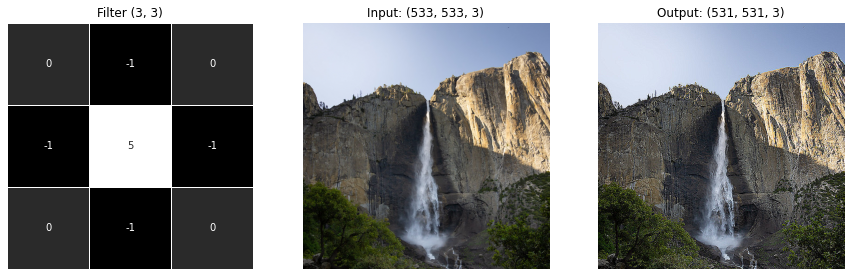

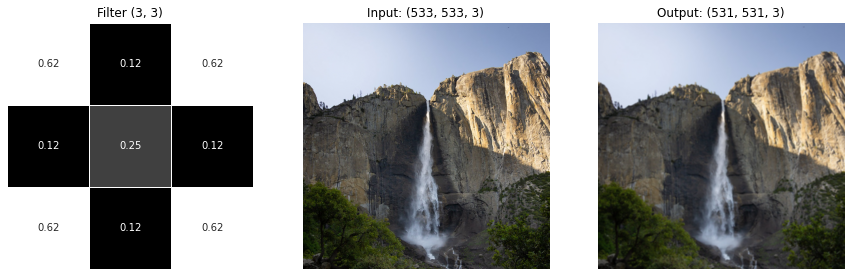

In [12]:
show_convolution(emboss, crop_sample_img, np.clip(conv_nb(crop_sample_img, emboss, 1), 0., 1.), size=15)
show_convolution(sharpen, crop_sample_img, np.clip(conv_nb(crop_sample_img, sharpen, 1), 0., 1.), size=15)
show_convolution(blur, crop_sample_img, np.clip(conv_nb(crop_sample_img, blur, 1), 0., 1.), size=15)

### Benchmark

In [13]:
total_threads = 16
test_filter = np.eye(5)

rt_nb = np.zeros((total_threads, 3), dtype=np.float64)
trials = 7

rt_np = np.zeros(trials, dtype=np.float64)
rt_py = np.zeros(trials, dtype=np.float64)
rt_cy = np.zeros(trials, dtype=np.float64)

for i in range(trials):
    rt_np[i] = runtime(conv_np, crop_sample_img, test_filter, 1)['runtime']
    rt_py[i] = runtime(conv_py, crop_sample_img, test_filter, 1)['runtime']
    rt_cy[i] = runtime(conv_cy, crop_sample_img, test_filter, 1)['runtime']
    
rt_np = rt_np.mean()
rt_py = rt_py.mean()
rt_cy = rt_cy.mean()
    
for i in range(1, total_threads+1):
    trial_rt = np.zeros(trials, dtype=np.float64)
    
    for t in range(trials): 
        set_num_threads(i)
        rt = runtime(conv_nb, crop_sample_img, emboss, 1)['runtime']
        trial_rt[t] = rt
        
    rt_mean = np.mean(trial_rt)
    rt_stdev = np.std(trial_rt)
    rt_nb[i-1, :] = (i, rt_mean, rt_stdev)

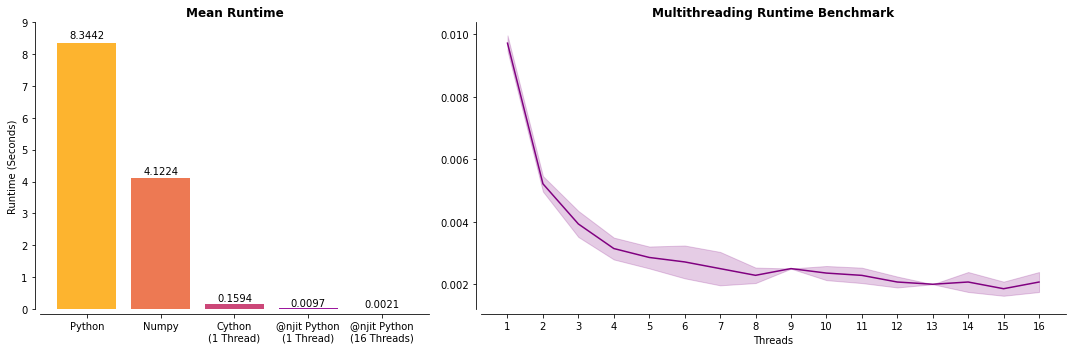

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), facecolor='white', 
                       gridspec_kw=dict(width_ratios=[2, 3]))

values = [rt_py, rt_np, rt_cy,
          rt_nb[0, 1],
          rt_nb[-1, 1]]
xticklabels = ['Python', 'Numpy', 'Cython\n(1 Thread)', 
               '@njit Python\n(1 Thread)',
               '@njit Python\n(16 Threads)']

pal = sns.color_palette('plasma', len(values))
pal = np.array(pal)[np.argsort(values)]

ax[0].bar(x=range(5), height=values, color=pal)
ax[0].set_xticks(ticks=range(5))

ax[0].set_xticklabels(xticklabels)
for n, p in enumerate(ax[0].patches):
    h = p.get_height()
    ax[0].text(p.get_x() + p.get_width()/2., 1.01 * h,
            f'{h:.4f}', ha='center', va='bottom')

ax[0].set_ylim((0, np.ceil(np.max(values))))
ax[0].set_title('Mean Runtime', weight='bold')
ax[0].set_ylabel('Runtime (Seconds)')

ax[1].plot(rt_nb[:, 0], rt_nb[:, 1], color='purple')
ax[1].fill_between(rt_nb[:, 0],
                rt_nb[:, 1] - rt_nb[:, 2],
                rt_nb[:, 1] + rt_nb[:, 2],
                alpha=0.2, color='purple')

ax[1].set_xticks(rt_nb[:, 0].astype(np.intc))
ax[1].set_title('Multithreading Runtime Benchmark', weight='bold')
ax[1].set_xlabel('Threads')

sns.despine(offset=5)
plt.tight_layout()
plt.show()

___